In [7]:
%load_ext autoreload
%autoreload 2
import siren
from siren.SIREN_Controller import SIREN_Controller
import os
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
plt.style.use("figures.mplstyle")
from SIREN_Simulation import RunLHCbMuonSimulation
from SIREN_SimulationHelpers import PrepareSIRENInputFromLHCb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
forward_flux_files = {
    "LHC13":{
        "light":["DPMJET", "EPOSLHC", "PYTHIA8", "QGSJET", "SIBYLL"],
        "charm":["BDGJKR", "BKRS", "BKSS", "MS", "SIBYLL"]
    },
    "Large":{
        "light":["EPOSLHC"],
        "charm":["BKRS"]
    },
    "Run3":{
        "light":["EPOSLHC"],
        "charm":["POWHEG+P8monash"]
    },
    "VLarge":{
        "light":["EPOSLHC","SIBYLL"],
        "charm":["BKRS"]
    }
}
primaries = [#12,-12,
             14,-14]
             #16,-16]
data = {}
for prefix,parent_dict in forward_flux_files.items():
    if prefix!="LHC13": continue
    for parent,generators in parent_dict.items():
        for generator in generators:
            for primary in primaries:
                key = tuple((prefix,generator,parent,primary))
                print(key)
                siren_input_file = "Data/SIREN/Input/LHCb_%s_%s_%s_%s"%(prefix,generator,parent,primary)
                if not os.path.isfile(siren_input_file+".txt"):
                    print("Preparing",siren_input_file)
                    flux_data = PrepareSIRENInputFromLHCb(prefix,generator,parent)
                    for primary in primaries:
                        flux_data.query("PDG==@primary").to_csv(siren_input_file+"_%d.txt"%primary,index=False)
                siren_output_file = "Data/SIREN/Output/LHCb_%s_%s_%s_%s"%(prefix,generator,parent,primary)
                if not os.path.isfile(siren_output_file+".parquet"):
                    print("Running",siren_output_file)
                    RunLHCbMuonSimulation(prefix,generator,parent,
                                          int(1e6),siren_output_file)
                data[key] = ak.from_parquet(siren_output_file+".parquet")
                

('LHC13', 'DPMJET', 'light', 14)
('LHC13', 'DPMJET', 'light', -14)
('LHC13', 'EPOSLHC', 'light', 14)
('LHC13', 'EPOSLHC', 'light', -14)
('LHC13', 'PYTHIA8', 'light', 14)
('LHC13', 'PYTHIA8', 'light', -14)
('LHC13', 'QGSJET', 'light', 14)
('LHC13', 'QGSJET', 'light', -14)
('LHC13', 'SIBYLL', 'light', 14)
('LHC13', 'SIBYLL', 'light', -14)
('LHC13', 'BDGJKR', 'charm', 14)
('LHC13', 'BDGJKR', 'charm', -14)
('LHC13', 'BKRS', 'charm', 14)
('LHC13', 'BKRS', 'charm', -14)
('LHC13', 'BKSS', 'charm', 14)
('LHC13', 'BKSS', 'charm', -14)
('LHC13', 'MS', 'charm', 14)
('LHC13', 'MS', 'charm', -14)
('LHC13', 'SIBYLL', 'charm', 14)
('LHC13', 'SIBYLL', 'charm', -14)


# paper figures from SIREN

EPOSLHC BKSS
DPMJET BKRS
SIBYLL SIBYLL
QGSJET BDGJKR
PYTHIA8 MS


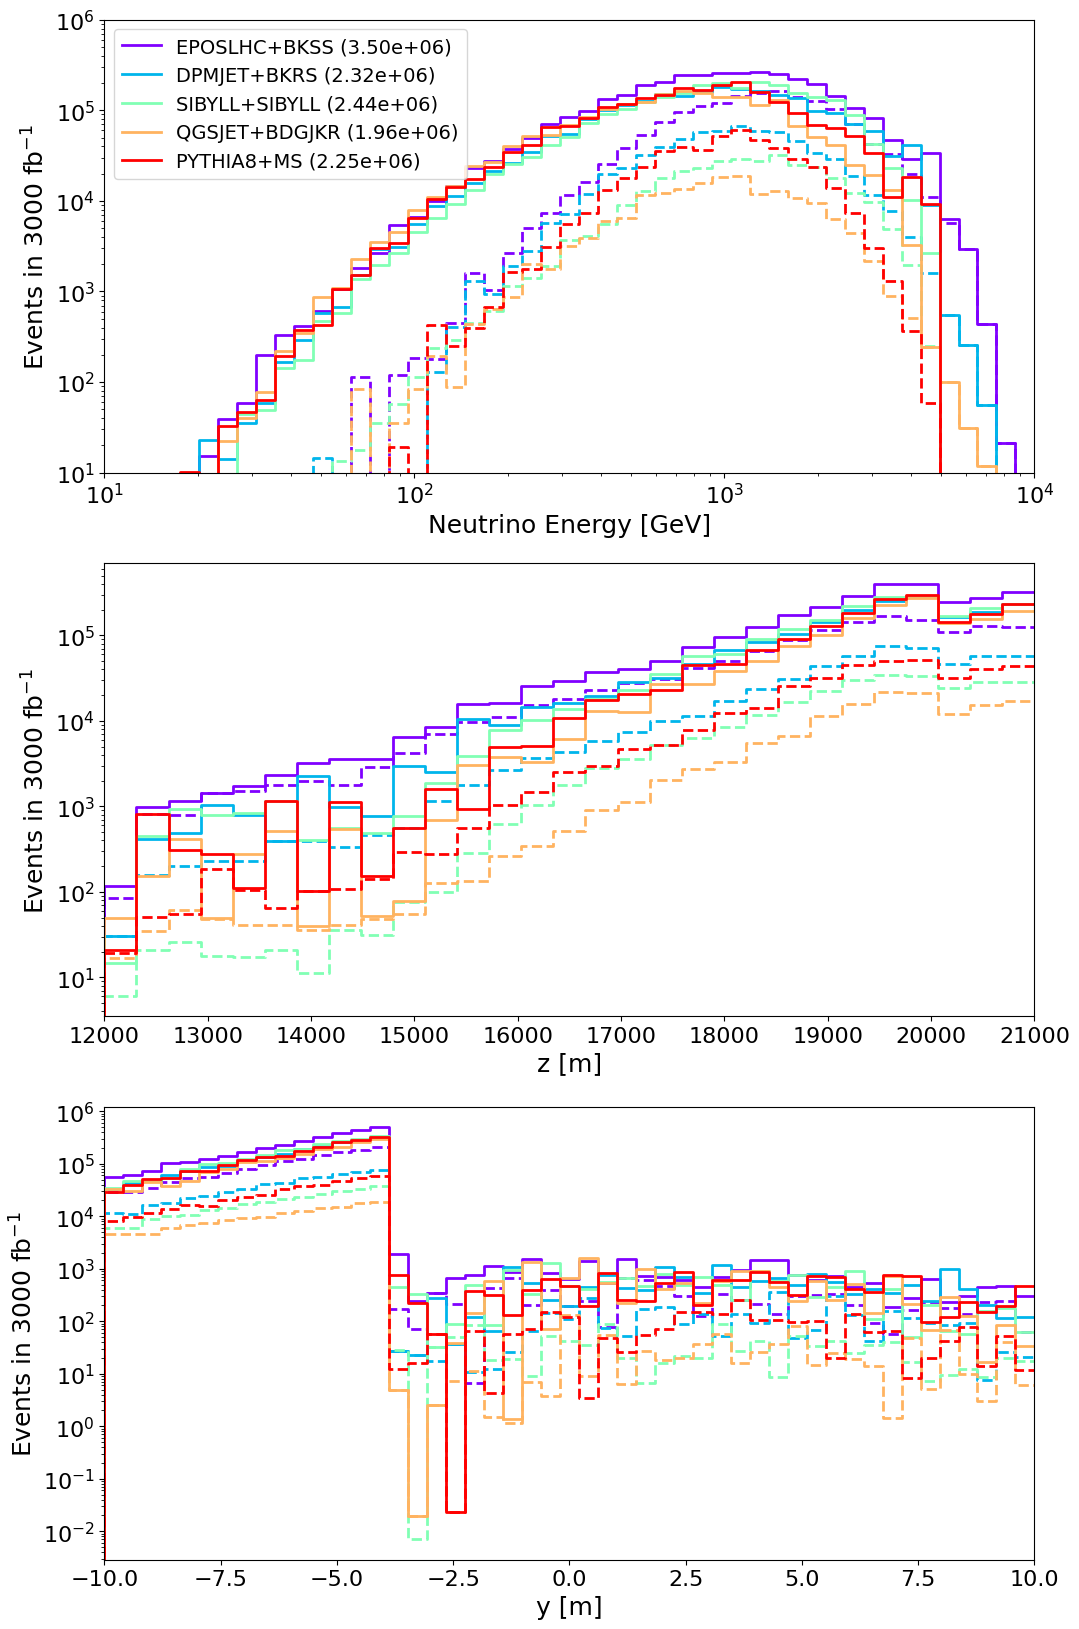

In [13]:
from matplotlib.pyplot import cm
prefix = "LHC13"
light_generators = ["EPOSLHC","DPMJET","SIBYLL","QGSJET","PYTHIA8"]
charm_generators = ["BKSS","BKRS","SIBYLL","BDGJKR","MS"]
color = iter(cm.rainbow(np.linspace(0, 1, len(light_generators))))

fig,ax = plt.subplots(3,1,figsize=(12,20))
e_bins = np.logspace(1,4)
xybins = np.linspace(-10,10,50)
zbins = np.linspace(12000,21000,30)

muon_depth = siren.distributions.LeptonDepthFunction()


for lg,cg in zip(light_generators,charm_generators):
    
    lkey = tuple((prefix,lg,"light"))
    ckey = tuple((prefix,cg,"charm"))
    
    print(lg,cg)
    c = next(color)
    
    ldata = ak.concatenate([data[lkey+(primary,)] for primary in primaries])
    cdata = ak.concatenate([data[ckey+(primary,)] for primary in primaries])
    
#     for dset in [ldata,cdata]:
    
#         if "hit_mask_survival" not in dset.fields:

#             dset["muon_max_col_depth"] = [muon_depth(siren.dataclasses.Particle.NuMu, muE)
#                                            for muE in np.squeeze(dset.secondary_momenta)[:,0,0]]

#             muonE = np.squeeze(dset["secondary_momenta"])[:,0,0]
            
#             for panel in [1,2,3]:

#                 dset["panel%d_muon_survival"%panel] = dset["panel%d_int_coldepths"%panel] < dset["muon_max_col_depth"]
#                 dset["panel%d_hit_mask_muon_survival"%panel] = np.logical_and(dset["panel%d_hit_mask"%panel],
#                                                                        np.any(dset["panel%d_muon_survival"%panel],axis=-1))
#             dset["hit_mask_muon_survival"] = np.logical_or.reduce((dset["panel1_hit_mask_muon_survival"],
#                                                                    dset["panel2_hit_mask_muon_survival"],
#                                                                    dset["panel3_hit_mask_muon_survival"]))
    
    weights = ldata.weights * ldata.hit_mask_muon_survival
    vx = np.squeeze(ldata.vertex)
    Ehist_l,_ = np.histogram(ldata.energy,bins=e_bins,weights=weights)
    zhist_l,_ = np.histogram(vx[:,-1],bins=zbins,weights=weights)
    yhist_l,_ = np.histogram(vx[:,1],bins=xybins,weights=weights)
    
    weights = cdata.weights * cdata.hit_mask_muon_survival
    vx = np.squeeze(cdata.vertex)
    Ehist_c,_ = np.histogram(cdata.energy,bins=e_bins,weights=weights)
    zhist_c,_ = np.histogram(vx[:,-1],bins=zbins,weights=weights)
    yhist_c,_ = np.histogram(vx[:,1],bins=xybins,weights=weights)
    
    Ehist = Ehist_l+Ehist_c
    zhist = zhist_l+zhist_c
    yhist = yhist_l+yhist_c
    tot = sum(Ehist)
    ax[0].step(e_bins,np.append([0],Ehist),color=c,label="%s+%s (%2.2e)"%(lg,cg,tot))
    ax[0].step(e_bins,np.append([0],Ehist_c),color=c,ls="--")
    ax[1].step(zbins,np.append([0],zhist),color=c)
    ax[1].step(zbins,np.append([0],zhist_c),color=c,ls="--")
    ax[2].step(xybins,np.append([0],yhist),color=c)
    ax[2].step(xybins,np.append([0],yhist_c),color=c,ls="--")

ax[0].loglog()
ax[0].set_ylim(1e1,1e6)
ax[1].semilogy()
ax[2].semilogy()

ax[0].set_xlim(e_bins[0],e_bins[-1])
ax[1].set_xlim(zbins[0],zbins[-1])
ax[2].set_xlim(xybins[0],xybins[-1])

ax[0].set_xlabel("Neutrino Energy [GeV]")
ax[1].set_xlabel("z [m]")
ax[2].set_xlabel("y [m]")
for i in range(3): ax[i].set_ylabel(r"Events in 3000$~{\rm fb}^{-1}$")
ax[0].legend()
plt.show()
            

In [34]:
data[key].panel1_hit_mask_muon_survival
data[key].panel2_hit_mask_muon_survival
data[key].panel3_hit_mask_muon_survival
sum(data[key].panel2_hit_mask_muon_survival & 
    np.logical_not(data[key].panel1_hit_mask_muon_survival) &
    np.logical_not(data[key].panel3_hit_mask_muon_survival))
#sum(data[key].panel2_hit_mask_muon_survival)

354

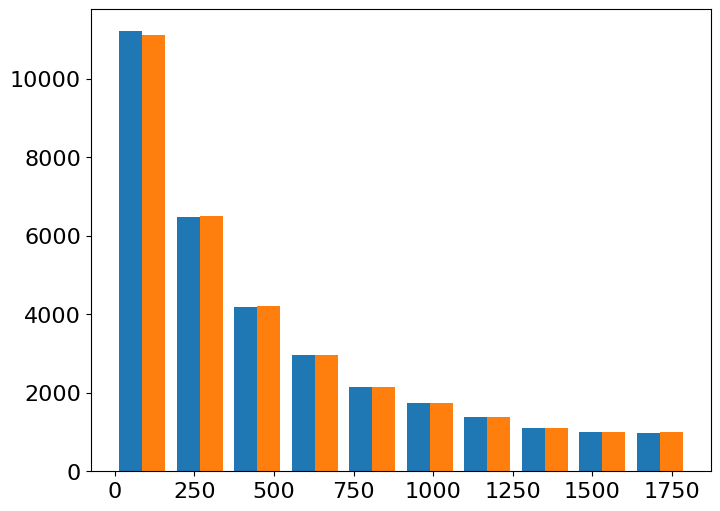

['event_weight',
 'event_gen_time',
 'event_weight_time',
 'event_global_time',
 'num_interactions',
 'vertex',
 'in_fiducial',
 'primary_type',
 'target_type',
 'num_secondaries',
 'secondary_types',
 'primary_momentum',
 'secondary_momenta',
 'parent_idx',
 'int_probs',
 'PDG',
 'bjorken_x',
 'bjorken_y',
 'energy',
 'hPDG',
 'thx',
 'thy',
 'wgt',
 'panel1_int_locations',
 'panel1_int_distances',
 'panel1_int_coldepths',
 'panel1_hit_mask',
 'panel2_int_locations',
 'panel2_int_distances',
 'panel2_int_coldepths',
 'panel2_hit_mask',
 'panel3_int_locations',
 'panel3_int_distances',
 'panel3_int_coldepths',
 'panel3_hit_mask',
 'weights',
 'hit_mask']

In [77]:
panel1_hitdata = data[lkey][data[lkey].panel1_hit_mask]
plt.hist(panel1_hitdata.panel1_int_distances)
plt.show()
panel1_hitdata.fields

(array([[2.7024e+04, 1.6990e+03, 1.1410e+03, 8.5900e+02, 5.8600e+02,
         3.6100e+02, 2.4500e+02, 1.3300e+02, 5.5000e+01, 3.1000e+01],
        [1.2400e+02, 2.4500e+02, 2.7900e+02, 2.3500e+02, 2.3500e+02,
         1.4600e+02, 1.0200e+02, 6.9000e+01, 3.2000e+01, 5.0000e+00],
        [2.2000e+01, 6.8000e+01, 8.8000e+01, 7.1000e+01, 6.2000e+01,
         5.3000e+01, 3.1000e+01, 1.7000e+01, 1.8000e+01, 3.0000e+00],
        [8.0000e+00, 1.9000e+01, 2.8000e+01, 2.3000e+01, 2.5000e+01,
         1.6000e+01, 3.0000e+00, 6.0000e+00, 4.0000e+00, 2.0000e+00],
        [2.0000e+00, 6.0000e+00, 6.0000e+00, 1.1000e+01, 1.5000e+01,
         9.0000e+00, 8.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00],
        [0.0000e+00, 5.0000e+00, 2.0000e+00, 7.0000e+00, 3.0000e+00,
         4.0000e+00, 4.0000e+00, 7.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
         4.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000

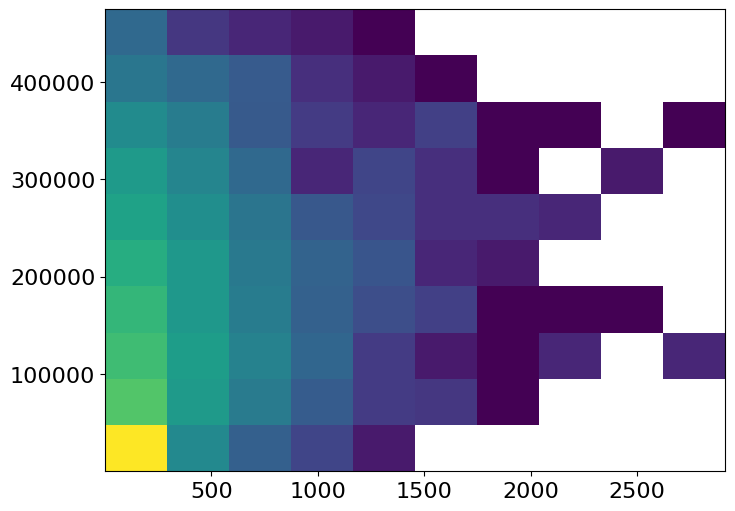

In [65]:
from matplotlib.colors import LogNorm
plt.hist2d(np.array(panel1_hitdata.weights),
           np.array(panel1_hitdata.panel1_int_coldepths[:,-1]),
           norm=LogNorm())